<a href="https://colab.research.google.com/github/abhaymittal2001/Assignments/blob/main/ASS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#20EE10002

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image

train_csv_path = r"C:\Users\ABHAY MITTAL\Desktop\DLFA\archive (1)\train.csv"
train_df = pd.read_csv(train_csv_path)
train_df

# Path to the folder containing images
images_folder = r"C:\Users\ABHAY MITTAL\Desktop\DLFA\archive (1)\clips-data-2020\clips"

# Calculate mean and standard deviation for each channel
red_channel_mean = [0]
green_channel_mean = [0]
blue_channel_mean = [0]
red_channel_std = [0]
green_channel_std = [0]
blue_channel_std = [0]

for image_id in train_df['id']:
    # Load image
#     image_path = os.path.join(images_folder, 'clips-' + str(image_id) + '.png')
    image_name = f"clips-{image_id}"
    image_path = os.path.join(images_folder, f"{image_name}.png")
    image = np.array(Image.open(image_path))

    # Compute mean and std for each channel
    red_channel_mean.append(np.mean(image[:, :, 0]))
    green_channel_mean.append(np.mean(image[:, :, 1]))
    blue_channel_mean.append(np.mean(image[:, :, 2]))

    red_channel_std.append(np.std(image[:, :, 0]))
    green_channel_std.append(np.std(image[:, :, 1]))
    blue_channel_std.append(np.std(image[:, :, 2]))

# Compute overall mean and std for each channel
overall_red_mean = np.mean(red_channel_mean)
overall_green_mean = np.mean(green_channel_mean)
overall_blue_mean = np.mean(blue_channel_mean)

overall_red_std = np.mean(red_channel_std)
overall_green_std = np.mean(green_channel_std)
overall_blue_std = np.mean(blue_channel_std)

print("Overall Mean of Red Channel:", overall_red_mean)
print("Overall Mean of Green Channel :", overall_green_mean)
print("Overall Mean of Blue Channel :", overall_blue_mean)

print("Overall Red Channel  standard deviation:", overall_red_std)
print("Overall Green Channel  standard deviation:", overall_green_std)
print("Overall Blue Channel standard deviation:", overall_blue_std)


Overall Red Channel Mean: 233.46112455825806
Overall Green Channel Mean: 235.74692612686158
Overall Blue Channel Mean: 241.6147343536377
Overall Red Channel Std: 36.95789980460783
Overall Green Channel Std: 32.839888156593226
Overall Blue Channel Std: 27.666827695642617


In [ ]:
train_df

,id,clip_count
0,30001,11
1,30002,2
2,30003,26
3,30004,41
4,30005,49
...,...,...
19995,49996,35
19996,49997,54
19997,49998,72
19998,49999,24


In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os

class ClipDataset(Dataset):
    def __init__(self, image_ids, csv_file, root_dir, roll_number, transform=None):
        self.image_ids = image_ids
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.roll_number = roll_number
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, 'clips-' + str(self.image_ids[idx]) + '.png')
        image = plt.imread(img_name)
        if image.shape[2] == 4:
            image = image[:, :, :3]
        label = int(self.annotations.loc[self.annotations['id'] == self.image_ids[idx], 'clip_count'])

        # Convert image to tensor and print shape
        image_tensor = torch.tensor(image)
        print("Original image shape:", image_tensor.shape)

        # Resize image
        image_tensor = torch.tensor(image).permute(2, 0, 1)

        # Resize image
        resize_transform = transforms.Resize((28, 28))
        image = resize_transform(image_tensor)
        image=torch.tensor(image)

        print("k:",image.shape)


        # Random rotation augmentation
        x = self.roll_number
        angle = random.uniform(-x, x)
        image = transforms.functional.rotate(image, angle)

        # Random horizontal flipping
        prob = x / 100
        if random.random() < prob:
            image = transforms.functional.hflip(image)

        # Normalize each channel of the image
        image[:, :, 0] = (image[:, :, 0] - overall_red_mean) / overall_red_std
        image[:, :, 1] = (image[:, :, 1] - overall_green_mean) / overall_green_std
        image[:, :, 2] = (image[:, :, 2] - overall_blue_mean) / overall_blue_std

        # Convert to flattened 1D tensor
        image = image.view(-1)

        return image, label

# Sample usage:
# train_csv_path = '/kaggle/input/count-the-paperclips/train.csv'
# train_df = pd.read_csv(train_csv_path)

# Sampled image IDs for training, validation, and testing
sampled_image_ids = train_df['id'].tolist()
random.seed(42)  # For reproducibility
random.shuffle(sampled_image_ids)

train_image_ids = sampled_image_ids[:2000]
valid_image_ids = sampled_image_ids[2000:2250]
test_image_ids = sampled_image_ids[2250:2500]


roll_number = 2  # Replace with your roll number's last two digits

train_dataset = ClipDataset(train_image_ids,  r"C:\Users\ABHAY MITTAL\Desktop\DLFA\archive (1)\train.csv" , images_folder, roll_number)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size // 8)
        self.fc2 = nn.Linear(input_size // 8, input_size // 64)
        self.fc3 = nn.Linear(input_size // 64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Forward pass
def forward_pass(model, data_loader, device):
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    return images, outputs, labels
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load train.csv



In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load train.csv

# Create train and validation data loaders
roll_number = 2  # Replace with your roll number's last two digits
images_folder="/kaggle/input/count-the-paperclips/clips-data-2020/clips"
train_dataset = ClipDataset(train_image_ids, "/kaggle/input/count-the-paperclips/train.csv", images_folder, roll_number)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_dataset = ClipDataset(valid_image_ids, '/kaggle/input/count-the-paperclips/train.csv', images_folder, roll_number)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_dataset = ClipDataset(test_image_ids, '/kaggle/input/count-the-paperclips/train.csv', images_folder, roll_number)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
# Initialize model
model = MLP(28*28*3)
model.to(device)


MLP(
  (fc1): Linear(in_features=2352, out_features=294, bias=True)
  (fc2): Linear(in_features=294, out_features=36, bias=True)
  (fc3): Linear(in_features=36, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# Forward pass for one batch
images, outputs, labels = forward_pass(model, train_loader, device)
print("Shape of images:", images.shape)
print("Predicted outputs:", outputs)
print("Ground truth labels:", labels)

# Print model summary
print(model)

Original image shape: torch.Size([256, 256, 3])
k: torch.Size([3, 28, 28])
Original image shape: torch.Size([256, 256, 3])
k: torch.Size([3, 28, 28])
Original image shape: torch.Size([256, 256, 3])
k: torch.Size([3, 28, 28])
Original image shape: torch.Size([256, 256, 3])
k: torch.Size([3, 28, 28])
Original image shape: torch.Size([256, 256, 3])
k: torch.Size([3, 28, 28])
Original image shape: torch.Size([256, 256, 3])
k: torch.Size([3, 28, 28])
Original image shape: torch.Size([256, 256, 3])
k: torch.Size([3, 28, 28])
Original image shape: torch.Size([256, 256, 3])
k: torch.Size([3, 28, 28])
Input image shape: torch.Size([2352])


/tmp/ipykernel_33/1362970395.py:34: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  label = int(self.annotations.loc[self.annotations['id'] == self.image_ids[idx], 'clip_count'])
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/tmp/ipykerne

In [ ]:
# Forward pass for one batch
images, outputs, labels = forward_pass(model, train_loader, device)
print("Shape of images:", images.shape)
print("Predicted outputs:", outputs)
print("Ground truth labels:", labels)

# Print model summary
print(model)

Original image shape: torch.Size([256, 256, 3])
k: torch.Size([3, 28, 28])
Original image shape: torch.Size([256, 256, 3])
k: torch.Size([3, 28, 28])
Original image shape: torch.Size([256, 256, 3])
k: torch.Size([3, 28, 28])
Original image shape: torch.Size([256, 256, 3])
k: torch.Size([3, 28, 28])
Original image shape: torch.Size([256, 256, 3])
k: torch.Size([3, 28, 28])
Original image shape: torch.Size([256, 256, 3])
k: torch.Size([3, 28, 28])
Original image shape: torch.Size([256, 256, 3])
k: torch.Size([3, 28, 28])
Original image shape: torch.Size([256, 256, 3])
k: torch.Size([3, 28, 28])
Shape of images: torch.Size([8, 2352])
Predicted outputs: tensor([[-0.4912],
        [-0.4691],
        [-0.4744],
        [-0.5055],
        [-0.4692],
        [-0.4859],
        [-0.5000],
        [-0.4804]], grad_fn=<AddmmBackward0>)
Ground truth labels: tensor([46, 40, 36, 26, 33,  0, 27, 43])
MLP(
  (fc1): Linear(in_features=2352, out_features=294, bias=True)
  (fc2): Linear(in_features=294, 

/tmp/ipykernel_33/1362970395.py:34: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  label = int(self.annotations.loc[self.annotations['id'] == self.image_ids[idx], 'clip_count'])
/tmp/ipykernel_33/1362970395.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image=torch.tensor(image)


100%|██████████| 20/20 [03:29<00:00, 10.50s/it]


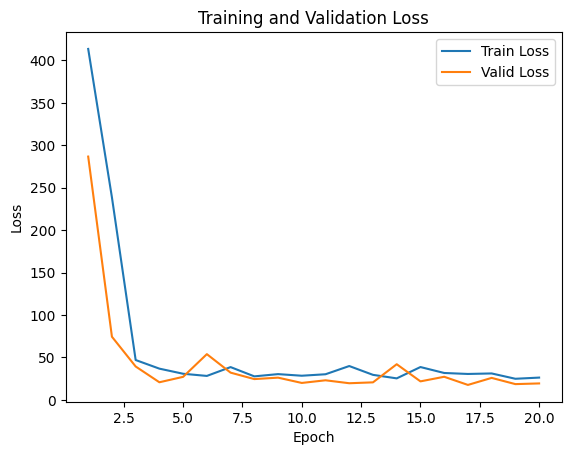

NameError: name 'test_data' is not defined

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import numpy as np

# ... rest of your imports (Dataset, DataLoader, MLP models, etc.)

def train_and_evaluate_model(
    model, train_loader, valid_loader, test_loader, device, lr=0.001, epochs=20
):



    warnings.filterwarnings("ignore")  # Temporarily suppress warnings

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')

    for epoch in tqdm(range(epochs)):
        model.train()
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_valid_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.float().unsqueeze(1))
                running_valid_loss += loss.item() * inputs.size(0)

        epoch_valid_loss = running_valid_loss / len(valid_loader.dataset)
        valid_losses.append(epoch_valid_loss)

        if epoch_valid_loss < best_valid_loss:
            best_valid_loss = epoch_valid_loss
            torch.save(model.state_dict(), 'best_model.pth')

    # Load best model and evaluate on test set
    best_model = MLP(28 * 28 * 3)  # Assuming MLP model with correct input size
    best_model.load_state_dict(torch.load('best_model.pth'))
    best_model.to(device)

    test_losses = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = best_model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            test_losses.append(loss.item())

    average_test_loss = np.mean(test_losses)

    # Plot training and validation loss
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()




# Report average MSE on test set
average_test_loss = np.mean(test_losses)
print("Average MSE on test set:", average_test_loss)
warnings.filterwarnings("default")

100%|██████████| 20/20 [03:32<00:00, 10.63s/it]


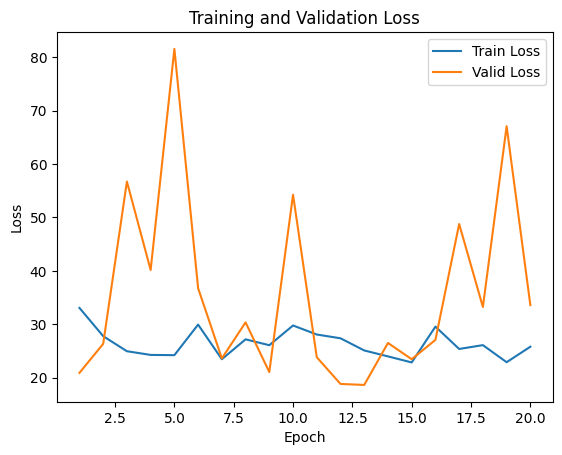

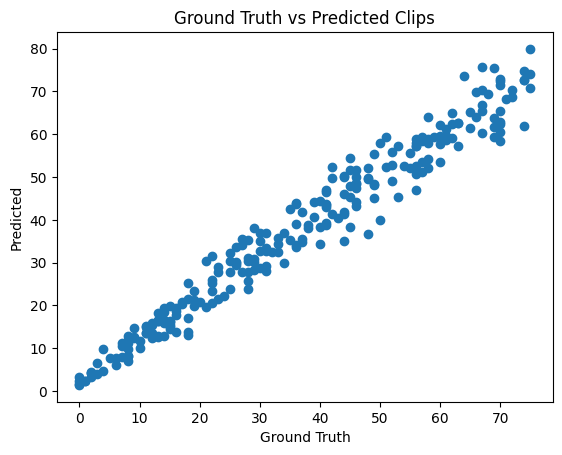

Average MSE on test set: 19.862068593502045


In [ ]:
# Train the model
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Your code here

# Reset warnings filter


import torch.optim as optim

from tqdm import tqdm
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_losses = []
valid_losses = []
best_valid_loss = float('inf')

for epoch in tqdm(range(20)):
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            running_valid_loss += loss.item()
    epoch_valid_loss = running_valid_loss / len(valid_loader)
    valid_losses.append(epoch_valid_loss)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'best_model.pth')

plt.plot(range(1, 21), train_losses, label='Train Loss')
plt.plot(range(1, 21), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

best_model = MLP(28*28*3)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.to(device)
test_losses = []
criterion = nn.MSELoss()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        loss = criterion(outputs, labels.float().unsqueeze(1))
        test_losses.append(loss.item())

# Plot ground truth vs predicted clips
test_predictions = []
test_labels = []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = best_model(inputs)
    test_predictions.extend(outputs.cpu().detach().numpy().flatten())
    test_labels.extend(labels.cpu().detach().numpy())

plt.scatter(test_labels, test_predictions)
plt.xlabel('Ground Truth')
plt.ylabel('Predicted')
plt.title('Ground Truth vs Predicted Clips')
plt.show()

# Report average MSE on test set
average_test_loss = np.mean(test_losses)
print("Average MSE on test set:", average_test_loss)
warnings.filterwarnings("default")